Using device: cuda


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


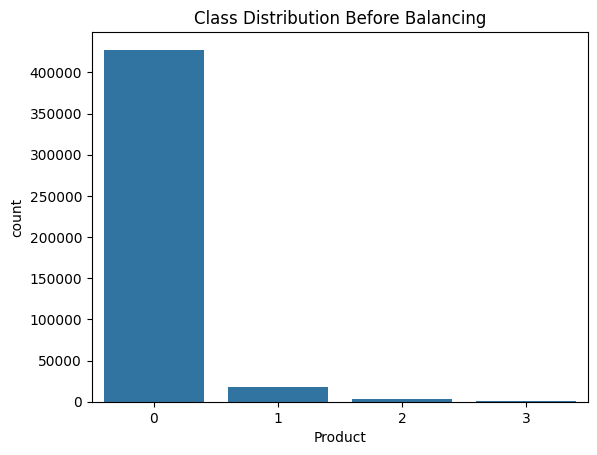

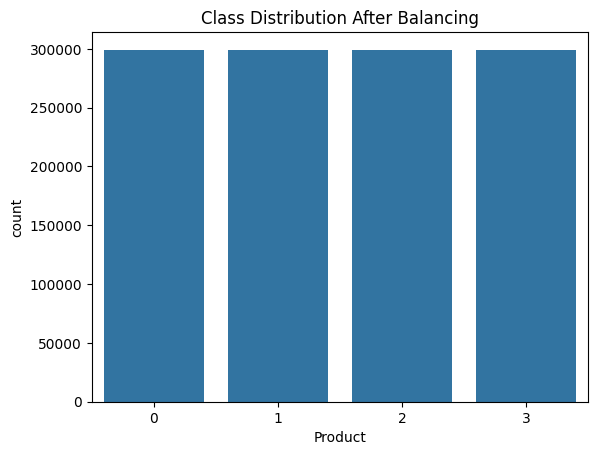

Epoch 1/5, Train Loss: 0.1426, Val Loss: 0.1727


Epoch 2/5, Train Loss: 0.1341, Val Loss: 0.1569


Epoch 3/5, Train Loss: 0.1331, Val Loss: 0.1741


Epoch 4/5, Train Loss: 0.1326, Val Loss: 0.1493


Epoch 5/5, Train Loss: 0.1324, Val Loss: 0.1446
              precision    recall  f1-score   support

      Credit       1.00      0.99      1.00    128241
        Debt       1.00      1.00      1.00      5536
        Loan       0.88      0.89      0.88      1106
    Mortgage       0.43      0.93      0.59       428

    accuracy                           0.99    135311
   macro avg       0.83      0.95      0.87    135311
weighted avg       1.00      0.99      0.99    135311

Text: I have an issue with my credit report being incorrect.
Predicted Category: Credit

Text: Debt collection agency is harassing me.
Predicted Category: Credit

Text: I need help with my student loan repayment.
Predicted Category: Loan

Text: My mortgage payment was miscalculated.
Predicted Category: Mortgage



In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from tqdm import tqdm

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Load dataset
df = pd.read_csv("https://files.consumerfinance.gov/ccdb/complaints.csv.zip", compression='zip', low_memory=False, nrows=500000)
df = df[['Product', 'Issue', 'Sub-issue']].dropna()

# Function to classify product category
def classify_product(text):
    text = text.lower()
    if any(word in text for word in ["credit reporting", "credit repair", "other"]):
        return 0
    if "debt collection" in text:
        return 1
    if any(word in text for word in ["loan", "consumer loan"]):
        return 2
    if "mortgage" in text:
        return 3
    return -1

df['Product'] = df[['Product', 'Issue', 'Sub-issue']].astype(str).agg(' '.join, axis=1).apply(classify_product)
df = df[df['Product'] != -1]
df['text'] = df['Issue'] + ' ' + df['Sub-issue']

# Visualize class distribution before balancing
sns.countplot(x=df['Product'])
plt.title("Class Distribution Before Balancing")
plt.show()

# Train-test split before oversampling
X_train_text, X_test_text, y_train, y_test = train_test_split(df['text'], df['Product'], test_size=0.3, random_state=42, stratify=df['Product'])

# Text vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

# Apply SMOTE only to training data
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

# Visualize class distribution after balancing
sns.countplot(x=y_train)
plt.title("Class Distribution After Balancing")
plt.show()

# Compute class weights for loss function
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long, device=device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Initialize model
input_dim = X_train_tensor.shape[1]
hidden_dim = 128
output_dim = len(np.unique(y_train))
model = BiLSTM(input_dim, hidden_dim, output_dim).to(device)

# Define optimizer, loss function, and scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Train model with early stopping and learning rate scheduler
epochs = 5
patience = 3
best_loss = float('inf')
stagnant_epochs = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for X_batch, y_batch in progress_bar:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        progress_bar.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        stagnant_epochs = 0
    else:
        stagnant_epochs += 1
        if stagnant_epochs >= patience:
            print("Early stopping triggered.")
            break

# Evaluate model and generate classification report
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print classification report
print(classification_report(y_true, y_pred, target_names=["Credit", "Debt", "Loan", "Mortgage"]))

# Function to predict category for a sample text
def predict_sample(text):
    text_vectorized = vectorizer.transform([text]).toarray()
    text_tensor = torch.tensor(text_vectorized, dtype=torch.float32, device=device)

    model.eval()
    with torch.no_grad():
        output = model(text_tensor)
        _, predicted = torch.max(output, 1)

    label_map = {0: "Credit", 1: "Debt", 2: "Loan", 3: "Mortgage"}
    return label_map[predicted.item()]

# Example sample predictions
sample_texts = [
    "I have an issue with my credit report being incorrect.",
    "Debt collection agency is harassing me.",
    "I need help with my student loan repayment.",
    "My mortgage payment was miscalculated."
]

for text in sample_texts:
    print(f"Text: {text}\nPredicted Category: {predict_sample(text)}\n")
